# Chapter 5 

**Convolutional neural networks**, also known as **convnets**, a type of deep-learning model almost universally used in computer vision applications. 
* We’ll learn to apply convnets to image classification problems—in particular those involving small training datasets, which are the most common use case if we aren’t a large tech company.

let’s take a practical look at a simple convnet example. It uses a convnet to classify MNIST digits, a task we performed in chapter 2 using a densely connected network (our test accuracy then was 97.8%). 
* Even though the convnet will be basic, its accuracy will blow out of the water that of the densely connected model.

The following lines of code show us what a basic convnet looks like. It’s a stack of **Conv2D** and **MaxPooling2D** layers.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
#  Instantiating a small convnet

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Importantly, a convnet takes as input tensors of shape (`image_height`, `image_width`, `image_channels`) (not including the batch dimension). 

In this case, we’ll configure the convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We’ll do this by passing the argument `input_shape=(28, 28, 1)` to the first layer.

In [3]:
# display the architecture of the convnet so far
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [4]:
# parameters calculation

param1 = 32*9+32
param2 = 32*64*9+64
param3 = 64*64*9+64

We can see that the output of every `Conv2D` and `MaxPooling2D` layer is a **3D tensor of shape (height, width, channels)**. The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (32 or 64).
 
The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely
connected classifier network like those we’re already familiar with: a **stack of Dense
layers**. 

These classifiers process vectors, which are **1D**, whereas the current output is a **3D tensor**.  
* First we have to **flatten the 3D outputs to 1D**, and then add a few Dense layers on top.

In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We’ll do **10-way classification**, using a **final layer with 10 outputs** and a **softmax activation**. Here’s what the network looks like now:

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

As we can see, the `(3, 3, 64)` outputs are flattened into vectors of shape `(576,)` before going through two Dense layers.

Now, let’s train the convnet on the MNIST digits.

In [7]:
from tensorflow.keras.datasets import mnist
from  tensorflow.keras.utils import to_categorical

In [8]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [9]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [10]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [11]:
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [12]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 66s 65ms/step - loss: 0.3964 - accuracy: 0.87270s - loss: 0.399
Epoch 2/5
938/938 [==============================] - 56s 60ms/step - loss: 0.0509 - accuracy: 0.9841
Epoch 3/5
938/938 [==============================] - 58s 62ms/step - loss: 0.0316 - accuracy: 0.9905
Epoch 4/5
938/938 [==============================] - 55s 59ms/step - loss: 0.0229 - accuracy: 0.99271s - loss: 0.0229 - accuracy: 0. - ETA: 1s - loss: 0.0229 - ac
Epoch 5/5
938/938 [==============================] - 74s 79ms/step - loss: 0.0184 - accuracy: 0.9940


In [13]:
# evaluate the model on the test data

test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 3s 9ms/step - loss: 0.0289 - accuracy: 0.9907


0.9907000064849854

* Whereas the densely connected network from chapter 2 had a test accuracy of **97.8%**, 
* The basic convnet has a test accuracy of **99.07%**: we decreased the error rate by **68%** (relative). Not bad!
 
But why does this simple convnet work so well, compared to a densely connected model? To answer this, let’s dive into what the **Conv2D** and **MaxPooling2D** layers do.

### The convolution operation

The fundamental difference between a densely connected layer and a convolution layer is this: 
* Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels),
* Whereas convolution layers learn local patterns

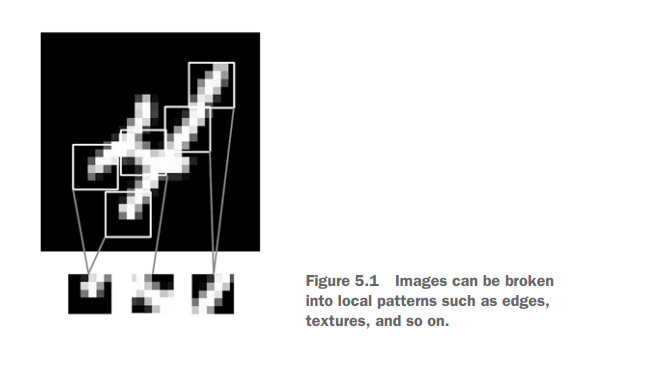

In the case of images, patterns found in **small 2D windows** of the inputs. 
* In the above example, these windows were all 3 × 3.

This key characteristic gives convnets two interesting properties:
1. **The patterns they learn are translation invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. 
    * A densely connected network would have to learn the pattern anew if it appeared at a new location. 
    * This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.

2. **They can learn spatial hierarchies of patterns** (see figure below). 
    * A first convolution layer will learn small local patterns such as edges, 
    * A second convolution layer will learn larger patterns made of the features of the first layers, and so on. 
    * This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical).

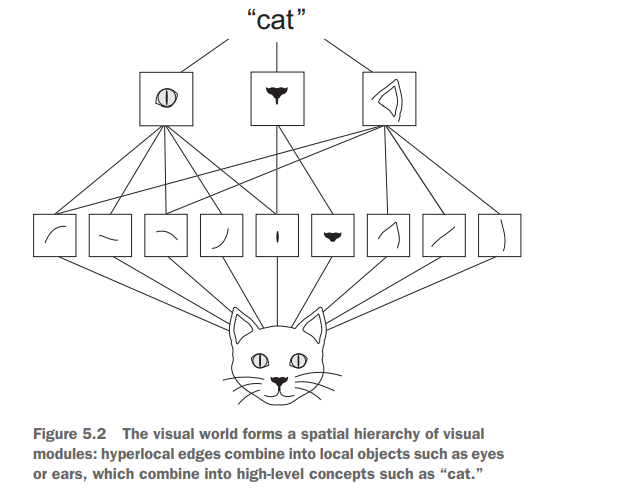

**Convolutions operate over 3D tensors**, called **feature maps**, with two spatial axes `(height and width)` as well as a `depth` axis (also called the **channels** axis). 
* For an **RGB image**, the dimension of the **depth axis is 3**, because the image has three color channels: **red**, **green**, and **blue**. 
* For a **black-and-white** picture, like the MNIST digits, the **depth is 1 (levels of gray)**. 

The convolution operation extracts patches from its **input feature map** and applies the same transformation to all of these patches, producing an **output feature map**. 
* This output feature map is still a 3D tensor: it has a width and a height.
* **Its depth can be arbitrary**, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, **they stand for filters**. 
* Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance

In the MNIST example, the first convolution layer takes a **feature map of size (28,28, 1)** and **outputs a feature map of size (26, 26, 32*)**: 
* It computes 32 filters over its input. 
* Each of these 32 output channels contains a 26 × 26 grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input.

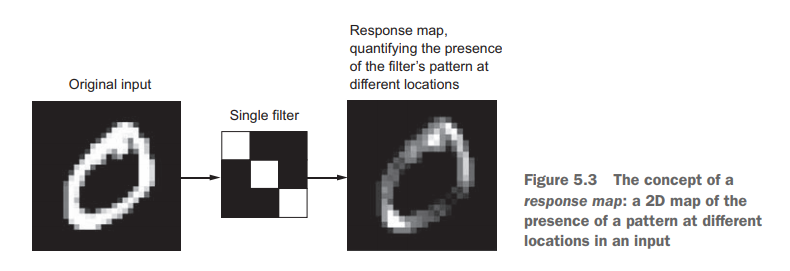

That is what the term feature map means: 
* Every dimension in the **depth axis is a feature (or filter)**, and 
* The 2D tensor **output[:, :, n]** is the **2D spatial map** of the response of this filter over the input.

Convolutions are defined by two key parameters:

* **Size of the patches extracted from the inputs**—These are typically 3 × 3 or 5 × 5. In the example, they were 3 × 3, which is a common choice.
* **Depth of the output feature map**—The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In Keras/Tensorflow Conv2D layers, these parameters are the first arguments passed to the layer: `Conv2D(output_depth, (window_height, window_width)).`

A convolution works by sliding these windows of size `3 × 3` or `5 × 5` over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features `(shape (window_height, window_width, input_depth))`. 

Each such **3D patch is then transformed** (via a tensor product with the same learned weight matrix, called the convolution kernel) **into a 1D vector of shape (output_depth,)**. 

All of these vectors are then spatially reassembled into a 3D output map of shape `(height, width, output_depth)`. 
* Every spatial location in the output feature map corresponds to the same location in the input feature map (for example, the lower-right corner of the output contains information about the lower-right corner of the input). For instance, with `3 × 3` windows, the vector `output[i, j, :]` comes from the 3D patch `input[i-1:i+1, j-1:j+1, :]`. The full process is detailed in figure 5.4.

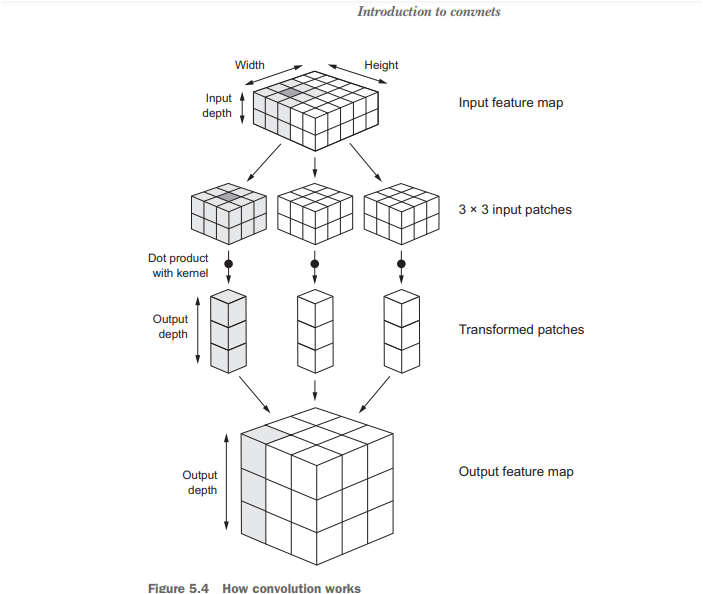

Note that the output width and height may differ from the input width and height. They may differ for two reasons:
1. Border effects, which can be countered by padding the input feature map
2. The use of strides

Let’s take a deeper look at these notions.

### UNDERSTANDING BORDER EFFECTS AND PADDING

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which we can center a 3 × 3 window, forming a 3 × 3 grid (see figure).

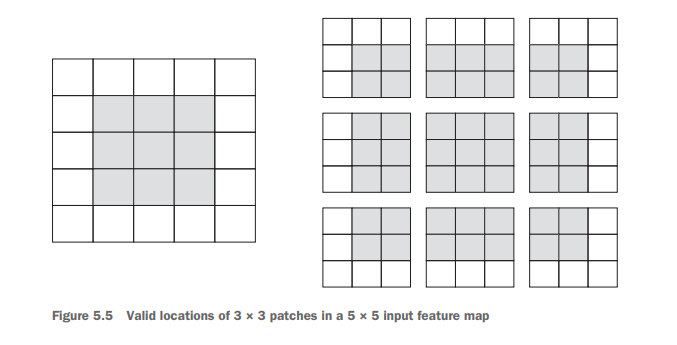

Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension, in this case. We can see this border effect in action in the earlier example: we start with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.

If we want to get an output feature map with the same spatial dimensions as the input, we can use **padding**. 

* Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. 
* For a 3 × 3 window, we add one column on the right, one column on the left, one row at the top, and one row at the bottom. For a 5 × 5 window, we add two rows (see figure).

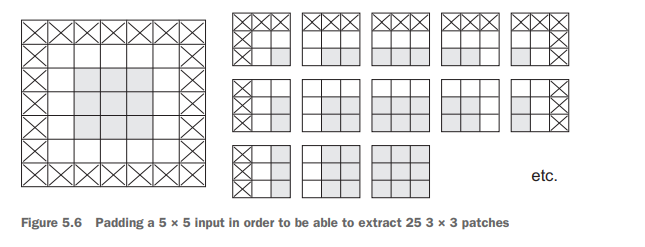

In Conv2D layers, padding is configurable via the padding argument, which takes two values: 

* **valid**, which means no padding (only valid window locations will be used); and 
* **same**, which means “pad in such a way as to have an output with the same width and height as the input.” 

The padding argument defaults to "valid". 

# UNDERSTANDING CONVOLUTION STRIDES

The other factor that can influence **output size** is the **notion of strides**. The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called **its stride**, which **defaults to 1**. 

It’s possible to have strided convolutions: convolutions with a stride higher than 1. 

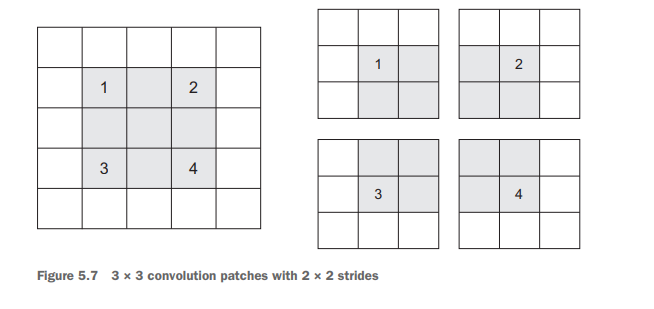

In figure, we can see the patches extracted by a `3 × 3` convolution with **stride 2** over a `5 × 5` input (without padding).

Using stride `2` means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). Strided convolutions are rarely used in practice, although they can come in handy for some types of models; it’s good to be familiar with the concept.
 
To downsample feature maps, instead of strides, we tend to use the **max-pooling** operation, which we saw in action in the first convnet example. Let’s look at it in more depth. 

### The max-pooling operation

In the convnet example, we may have noticed that the size of the feature maps is halved after every `MaxPooling2D` layer. For instance, before the first MaxPooling2D layers, the feature map is `26 × 26`, but the max-pooling operation halves it to `13 × 13`.
* That’s the role of max pooling: to aggressively downsample feature maps, much like strided convolutions.

Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation.
* A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. 
* On the other hand, convolution is typically done with 3 × 3 windows and no stride (stride 1).

Why downsample feature maps this way? Why not remove the max-pooling layers and keep fairly large feature maps all the way up? Let’s look at this option. The convolutional base of the model would then look like this:

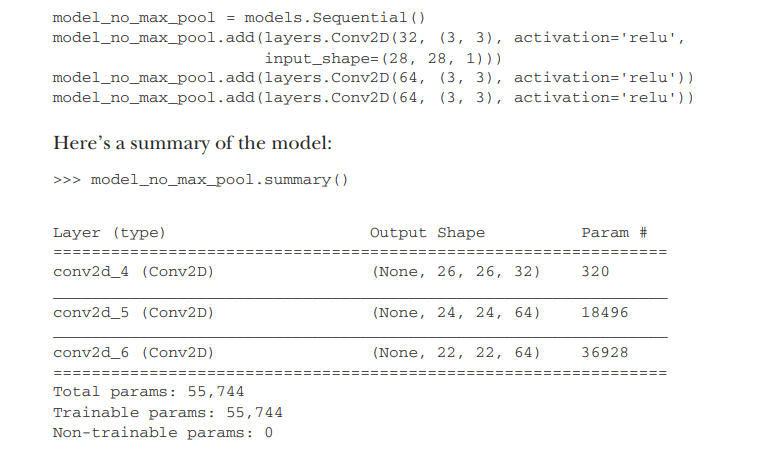

What’s wrong with this setup? Two things:

* It isn’t conducive to learning a spatial hierarchy of features. The `3 × 3` windows in the third layer will only contain information coming from `7 × 7` windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are `7 × 7` pixels!). We need the features from the last convolution layer to contain information about the totality of the input.

* The final feature map has `22 × 22 × 64 = 30,976` total coefficients per sample. This is huge. If were were to flatten it to stick a Dense layer of size `512` on top, that layer would have **15.8 million parameters**. This is far too large for such a small model and would result in intense overfitting.

In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover).
 
Note that max pooling isn’t the only way we can achieve such downsampling. As we already know, we can also use strides in the prior convolution layer. And we can use **average pooling** instead of **max pooling**, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. 

But max pooling tends to work better than these alternative solutions. In a nutshell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence, the term feature map), and it’s more informative to look at the maximal presence of different features than at their average presence. 

So the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause us to miss or dilute feature-presence information.

At this point, we should understand the basics of convnets—feature maps, convolution, and max poolin—and we know how to build a small convnet to solve a toy problem such as MNIST digits classification. 

Now let’s move on to more useful, practical applications. 